# Module loading

In [1]:
# modify this line to your local path
pwd = !pwd
path = str(pwd[0])
data_path = path + "/data/"
image_path = path + '/images/'

/Users/behind3220/Desktop/04. Side Project/tmp/Project4_205946238_PinHan Chen拷貝


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from IPython.display import Image, display
import seaborn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
from statsmodels.api import add_constant
import itertools
import lightgbm as lgb
import random

In [4]:
!pip install ydata_profiling
from ydata_profiling import ProfileReport
# !pip pycountry_convert
# import pycountry_convert as pc
!pip install scikit-optimize
from skopt import BayesSearchCV
# !pip install catboost
# from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.9/344.9 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 KB 8.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
  Attempting uninstall: visions

# Data Inspection (Question 1.1 ~ 1.4)

## Read Data

### Dataset 1: Diamond Characteristics

In [6]:
diamond_df = pd.read_csv(data_path + "diamonds.csv")
diamond_df = diamond_df.drop(['Unnamed: 0'], axis=1)
diamond_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,330,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,327,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,328,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,337,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,338,4.34,4.35,2.75


In [6]:
diamond_prof = ProfileReport(diamond_df, title="Profile Report for Diamond Dataset")
diamond_prof.to_widgets()
diamond_prof.to_file('diamond_prof.html')

/usr/local/lib/python3.9/dist-packages/ydata_profiling/profile_report.py:498: UserWarning: Ipywidgets is not yet fully supported on Google Colab (https://github.com/googlecolab/colabtools/issues/60).As an alternative, you can use the HTML report. See the documentation for more information.
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Dataset 2: Gas Turbine CO and NOx Emission Data Set

In [7]:
# merging the files
joined_files = os.path.join(data_path, "gt_201*.csv")
# A list of all joined files is returned
joined_list = glob.glob(joined_files)

df_list = []
for i in range(len(joined_list)):
  # read each csv into a dataframe
  tmp_df = pd.read_csv(joined_list[i])
  # catch the year of current csv file
  file_path = os.path.splitext(joined_list[i])[0]
  file_name = file_path.split('/')[-1]
  file_year = file_name.split('_')[-1]
  # add a new 'Year' column
  tmp_df['Year'] = int(file_year)
  # drop 'CO' column
  tmp_df = tmp_df.drop(['CO'], axis=1)
  # append current df into a df list
  df_list.append(tmp_df)

df_list[0].head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX,Year
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,81.952,2011
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,82.377,2011
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,83.776,2011
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,82.505,2011
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,82.028,2011


In [8]:
# merge 5 df into one dataframe
gas_df = df_list[0]
for i in range(1, 5):
  gas_df = pd.merge(gas_df, df_list[i], how='outer')
gas_df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX,Year
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,81.952,2011
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,82.377,2011
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,83.776,2011
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,82.505,2011
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,82.028,2011
...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,89.172,2015
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,88.849,2015
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,96.147,2015
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,64.738,2015


In [9]:
gas_prof = ProfileReport(gas_df, title="Profile Report for Gas Dataset")
gas_prof.to_widgets()
gas_prof.to_file('gas_prof.html')

/usr/local/lib/python3.9/dist-packages/ydata_profiling/profile_report.py:498: UserWarning: Ipywidgets is not yet fully supported on Google Colab (https://github.com/googlecolab/colabtools/issues/60).As an alternative, you can use the HTML report. See the documentation for more information.
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Question 1.1

Plot a heatmap of the Pearson correlation matrix of the dataset columns. 
Report which features have the highest absolute correlation with the target variable. 
In the context of either dataset, describe what the correlation patterns suggest.

### diamonds dataset

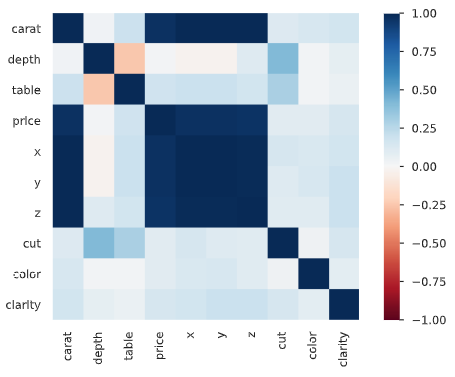

In [10]:
imageName = image_path + 'diamond_Q1_1.png'
display(Image(filename=imageName))

From above results, we can see that the features **'carat', 'x', 'y', and 'z'** have high absolute correlation with the target value 'price'. It suggests that the price of a diamond is highly correlated to its size. In which makes sense because we all know a diamond should be expensive when it's bigger.

### gas emission dataset

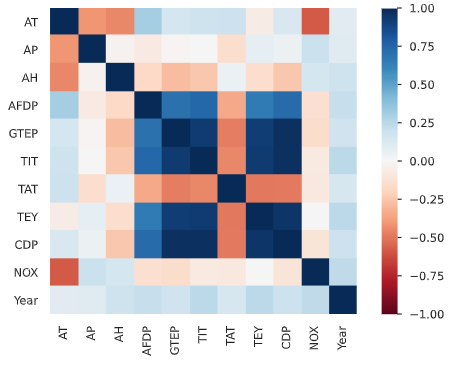

In [11]:
imageName = image_path + 'gas_Q1_1.png'
display(Image(filename=imageName))

From above results, we can see that only the features **'AP', and 'AH'** have positive correlation with the target value 'NOX'. Other features all have negative or zero correlation with the target value.

It implies that there are no significant features deciding the emission of gas NOx, we might need a more complicated model to analyze this dataset.

## Question 1.2

Plot the histogram of numerical features. 

### diamonds dataset

The numerical features of the diamond dataset: ['carat', 'depth', 'price', 'table', 'x', 'y', 'z']


histogram for carat :



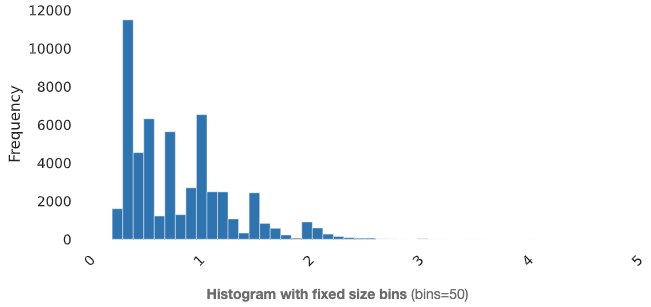


histogram for depth :



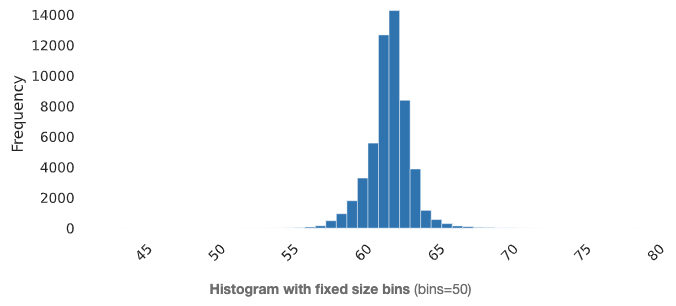


histogram for price :



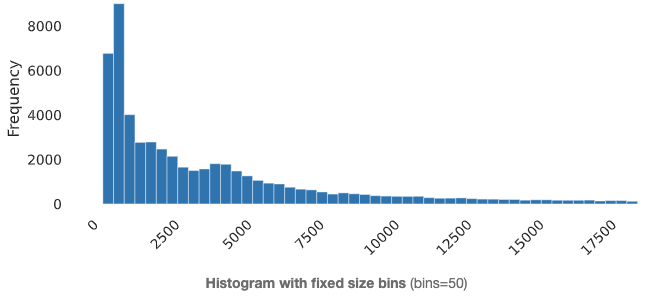


histogram for table :



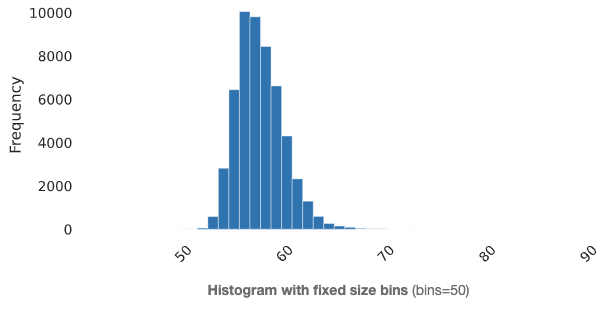


histogram for x :



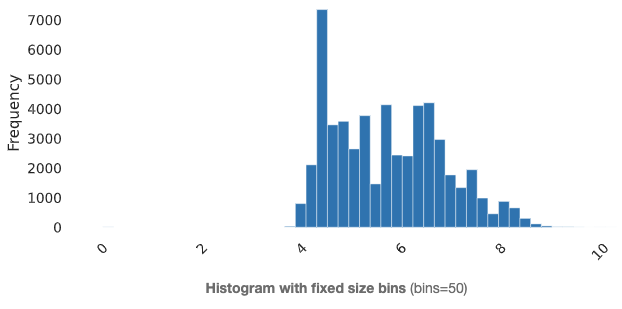


histogram for y :



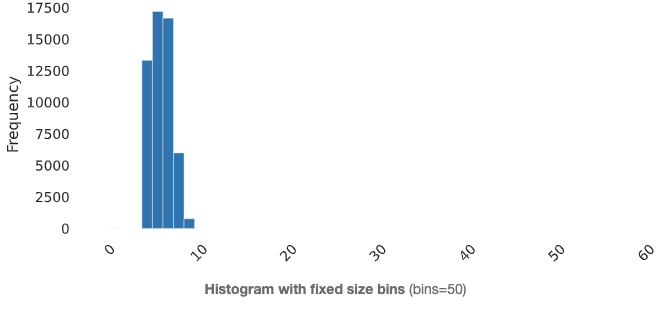


histogram for z :



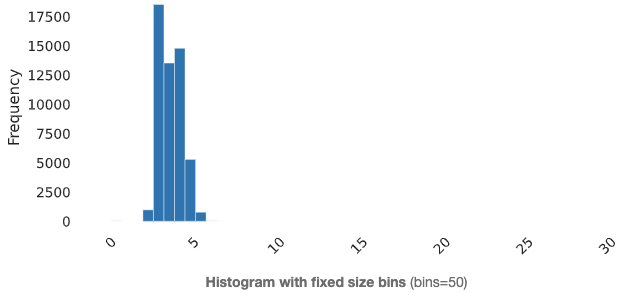

In [12]:
diamond_numer_list = ['carat', 'depth','price', 'table', 'x', 'y', 'z']
print('The numerical features of the diamond dataset:', [item for item in diamond_numer_list])
print('')
for item in diamond_numer_list:
  imageName = image_path + 'diamond_Q1_2_' + item + '.png'
  print('\nhistogram for', item, ':\n')
  display(Image(filename=imageName))

From above result, we can see that almost every numerical feature has skewness.

For features 'carat', 'price', 'table', 'x', 'y' and 'z', they have positive skewness.

For feature 'depth', it has mildly negative skewness.

### gas emission dataset

The numerical features of the gas dataset: ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'NOX']


histogram for AT :



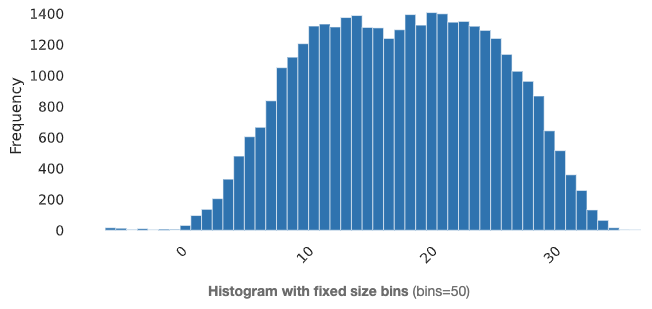


histogram for AP :



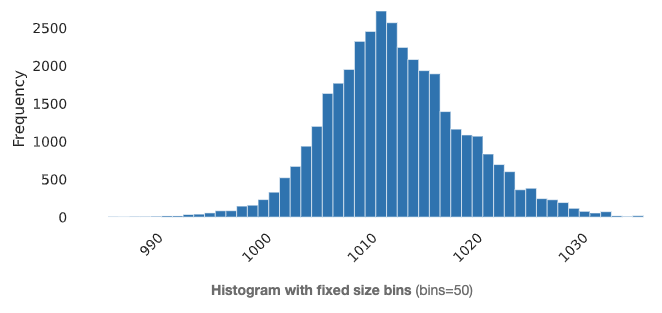


histogram for AH :



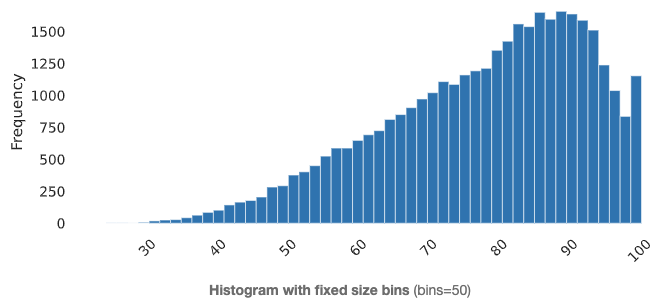


histogram for AFDP :



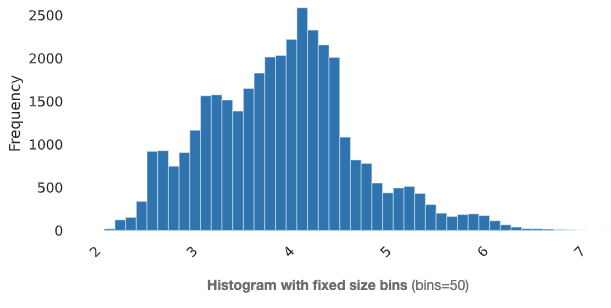


histogram for GTEP :



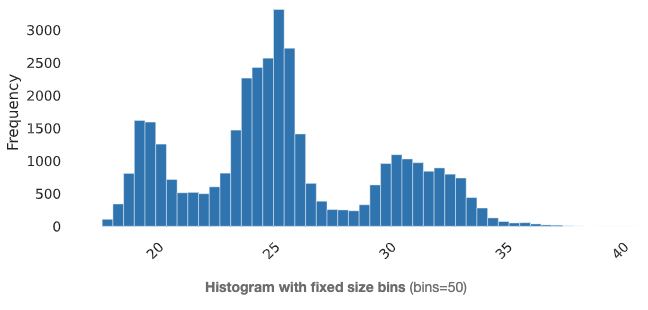


histogram for TIT :



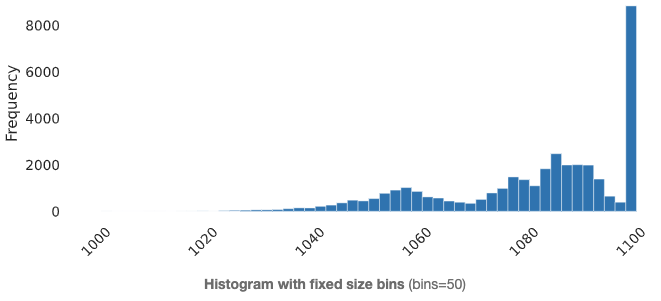


histogram for TAT :



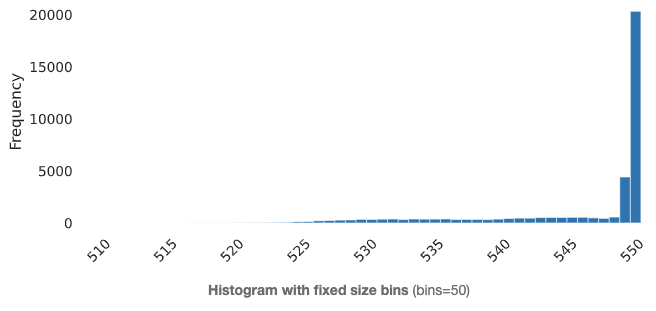


histogram for TEY :



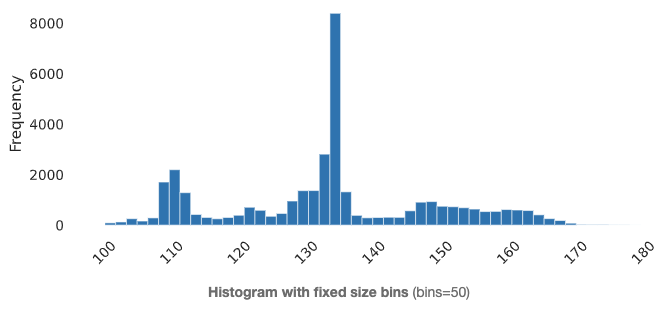


histogram for CDP :



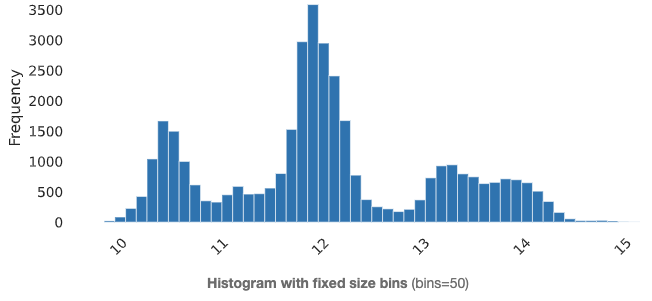


histogram for NOX :



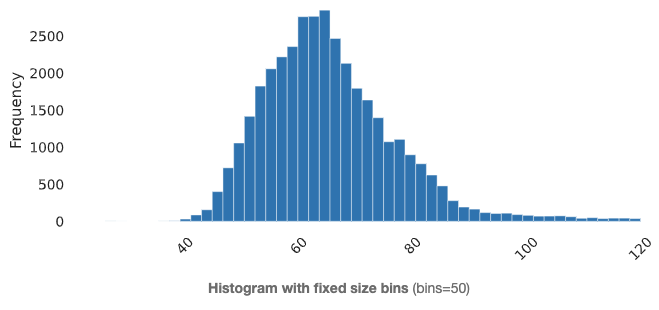

In [13]:
gas_numer_list = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'NOX']
print('The numerical features of the gas dataset:', [item for item in gas_numer_list])
print('')
for item in gas_numer_list:
  imageName = image_path + 'gas_Q1_2_' + item + '.png'
  print('\nhistogram for', item, ':\n')
  display(Image(filename=imageName))

From above result, we can see that almost every numerical feature has skewness.

For features 'AP', 'AFDP', 'GTEP', 'TEY', 'CDP' and 'NOX', they have positive skewness.

For feature 'AT', 'AH', 'TIT', and 'TAT', they have negative skewness.


What preprocessing can be done if the
distribution of a feature has high skewness?


If a distribution has high skewness, we can first remove outliers and do normalization on the data. If it still has high skewness, we can perform different transformations on it to reduce the skewness.

For example, we can use log transformation, square-loot transformation, or cube-root transformation to reduce the skewness.

## Question 1.3

Construct and inspect the box plot of categorical features vs target variable. What
do you find?

### diamonds dataset

The categorical features of the diamond dataset: ['cut', 'color', 'clarity']
box plot of cut :


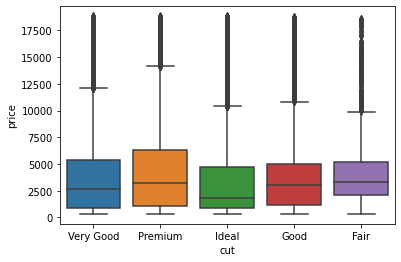

box plot of color :


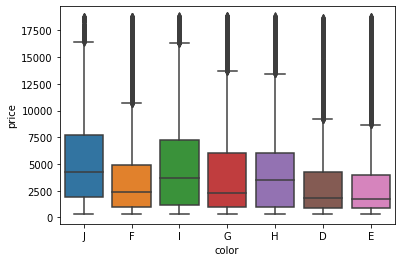

box plot of clarity :


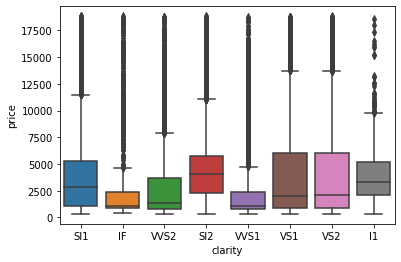

In [14]:
diamond_cat_list = ['cut','color','clarity']
print('The categorical features of the diamond dataset:', [item for item in diamond_cat_list])
for item in diamond_cat_list:
  print('box plot of', item, ':')
  seaborn.boxplot(x = diamond_df[item],y = diamond_df['price'], order=list(set(diamond_df[item])))
  plt.show()

From the result, it suggest that there are many outlier numbers in high price. Most of the data are distributed in lower price and there are no outliers in low price. On the other hand, as the cut of the diamond gets better (closer to premium), there is a trend suggest that the maximum price of it gets higher.

One possible reason for it might bacause that there are rarely expensive diamonds in the market. It's hard to generate a big (which is also expensive) diamond. The dealers are trying to get profit so they produce and sell diamond in an affordable price for normal customers. Therefore, you can see that the median, Q1, and Q3 are all located in a relatively lower price of the whole dataset no matter we take any categorical feature to inspect.


### gas emission dataset

The categorical features of the gas dataset: ['Year']
box plot of Year :


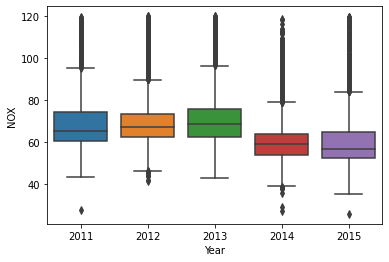

In [15]:
gas_cat_list = ['Year']
print('The categorical features of the gas dataset:', [item for item in gas_cat_list])
for item in gas_cat_list:
  print('box plot of', item, ':')
  seaborn.boxplot(x = gas_df[item],y = gas_df['NOX'], order=list(set(gas_df[item])))
  plt.show()

From above result, we can only tell that there are no significant differences between different years in this dataset.

The majority of this dataset are numerical features, we need further modeling to analyze this dataset as we mentioned before.

## Question 1.4

For the Diamonds dataset, plot the counts by color, cut and clarity.

For the Gas Emission dataset, plot the yearly trends for each feature and compare them. The data points don’t have timestamps but you may assume the indeces are times.

### diamonds dataset

<Axes: >

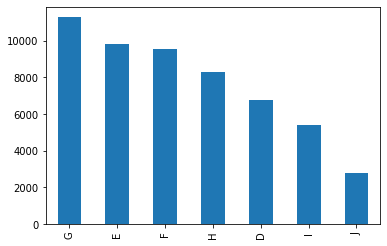

In [16]:
diamond_df['color'].value_counts().plot(kind='bar')

<Axes: >

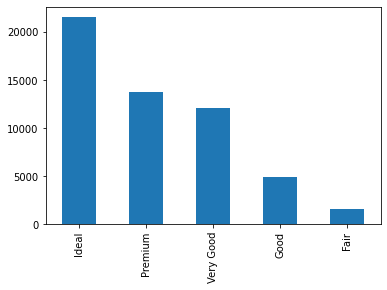

In [17]:
diamond_df['cut'].value_counts().plot(kind='bar')

<Axes: >

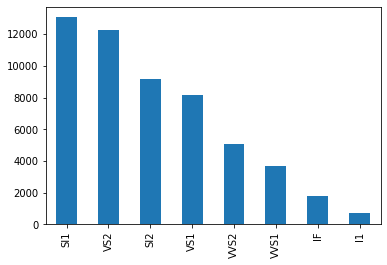

In [18]:
diamond_df['clarity'].value_counts().plot(kind='bar')

### gas emission dataset

In [19]:
def plt_year_trend(feature_name):
  year_list = [2011, 2012, 2013, 2014, 2015]
  for year in year_list:
    tmp_df = gas_df[gas_df['Year'] == year].reset_index(drop=True)
    plt.plot(np.arange(tmp_df.shape[0]), tmp_df[feature_name])
  plt.legend(year_list, loc='best')
  plt.grid(linestyle=':')
  plt.xlabel('timestamps (indices)')
  plt.ylabel(str(feature_name))
  plt.title(str(feature_name) + ' vs. timestamps (indices)')
  plt.show()

yearly trends for feature AT :


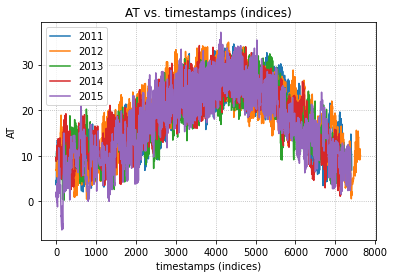

yearly trends for feature AP :


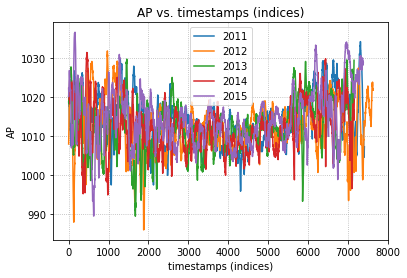

yearly trends for feature AH :


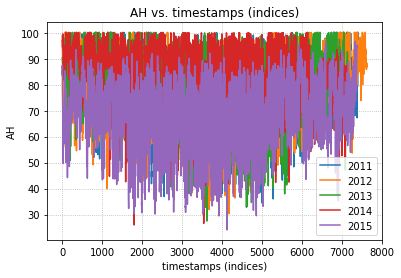

yearly trends for feature AFDP :


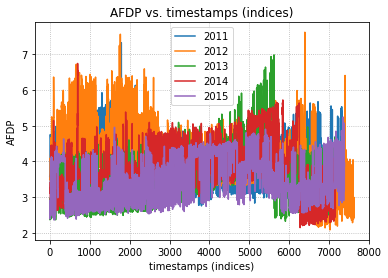

yearly trends for feature GTEP :


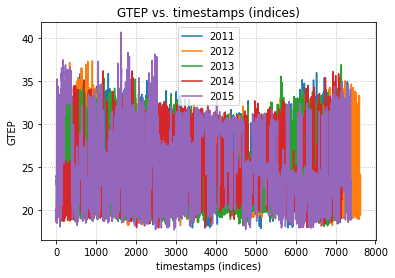

yearly trends for feature TIT :


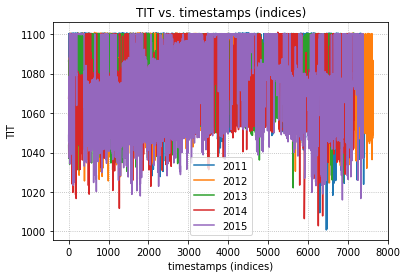

yearly trends for feature TAT :


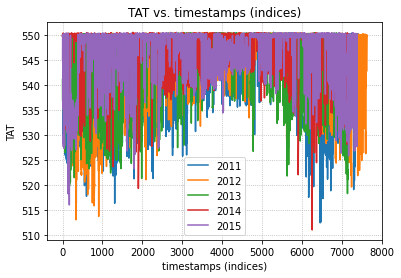

yearly trends for feature TEY :


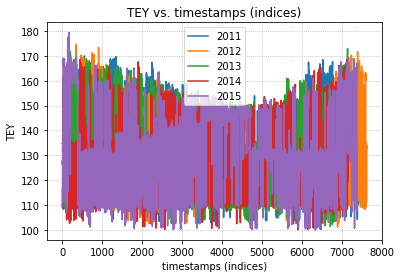

yearly trends for feature CDP :


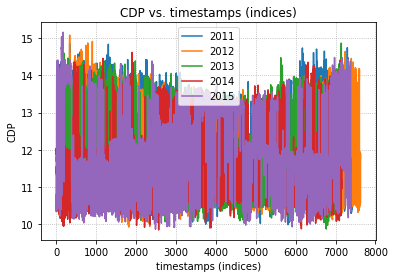

yearly trends for feature NOX :


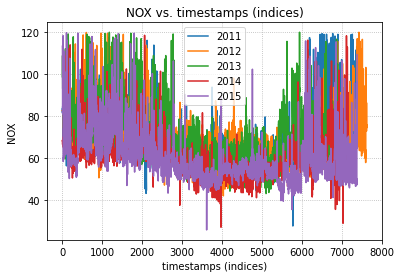

In [20]:
gas_numer_list = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'NOX']
for item in gas_numer_list:
  print('yearly trends for feature', item, ':')
  plt_year_trend(item)

## Choose diamonds dataset for further questions

After the investigation above, we choose the diamonds dataset to answer the following questions. 

Because its features are more clear and we are more familiar with this dataset. There is also significant correlation between some features. It should help us extract insight from the data.

# Data preprocessing

## Numerical encoding

In [7]:
# Numerical encoding for categorical features
dic_cut = {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5}
diamond_df['cut'] = diamond_df['cut'].map(dic_cut)
dic_color = {'J':1, 'I':2, 'H':3, 'G':4, 'F':5, 'E':6, 'D':7}
diamond_df['color'] = diamond_df['color'].map(dic_color)
dic_clarity = {'I1':1, 'SI2':2, 'SI1':3, 'VS2':4, 'VS1':5, 'VVS2':6, 'VVS1':7, 'IF':8}
diamond_df['clarity'] = diamond_df['clarity'].map(dic_clarity)
diamond_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,5,6,2,61.5,55.0,330,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,327,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,328,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,337,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,338,4.34,4.35,2.75


## Question 2.1 (Standardization)

Standardize feature columns and prepare them for training.

In [8]:
X=diamond_df.drop(['price'], axis=1)
y=diamond_df['price']
sc = StandardScaler()
X_s = sc.fit_transform(X)

## Question 2.2 (Feature Selection)

Describe how this step qualitatively affects the
performance of your models in terms of test RMSE. Is it true for all model types? Also
list two features for either dataset that has the lowest MI w.r.t to the target.

Here, we choose the basic regression models: linear regression, lasso regression and ridge regression to test the feature selection effect.

In [9]:
LR_mi_list = []
LR_f_list = []
Ridge_mi_list = []
Ridge_f_list = []
Lasso_mi_list = []
Lasso_f_list = []

for i in range(1, X.shape[1]):

  MI = SelectKBest(score_func=mutual_info_regression, k=i).fit_transform(X, y)
  F = SelectKBest(score_func=f_regression, k=i).fit_transform(X, y)

  LR_CV_MI = cross_validate(LinearRegression(), MI, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
  LR_mi_list.append(LR_CV_MI['test_neg_root_mean_squared_error'].mean())
  LR_CV_F = cross_validate(LinearRegression(), F, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
  LR_f_list.append(LR_CV_F['test_neg_root_mean_squared_error'].mean())

  Lasso_CV_MI = cross_validate(Lasso(), MI, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
  Lasso_mi_list.append(Lasso_CV_MI['test_neg_root_mean_squared_error'].mean())
  Lasso_CV_F = cross_validate(Lasso(), F, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
  Lasso_f_list.append(Lasso_CV_F['test_neg_root_mean_squared_error'].mean())

  Ridge_CV_MI = cross_validate(Ridge(), MI, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
  Ridge_mi_list.append(Ridge_CV_MI['test_neg_root_mean_squared_error'].mean())
  Ridge_CV_F = cross_validate(Ridge(), F, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
  Ridge_f_list.append(Ridge_CV_F['test_neg_root_mean_squared_error'].mean())

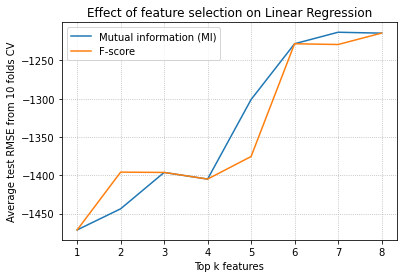

In [10]:
plt.plot(np.arange(1, len(LR_mi_list) + 1, 1), LR_mi_list)
plt.plot(np.arange(1, len(LR_f_list) + 1, 1), LR_f_list)
plt.legend(['Mutual information (MI)','F-score'], loc='best')
plt.grid(linestyle=':')
plt.xlabel('Top k features')
plt.ylabel('Average test RMSE from 10 folds CV')
plt.title('Effect of feature selection on Linear Regression')
plt.show()

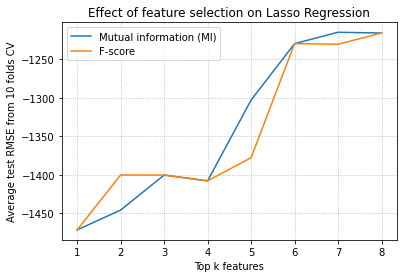

In [11]:
plt.plot(np.arange(1, len(Lasso_mi_list) + 1, 1), Lasso_mi_list)
plt.plot(np.arange(1, len(Lasso_f_list) + 1, 1), Lasso_f_list)
plt.legend(['Mutual information (MI)','F-score'], loc='best')
plt.grid(linestyle=':')
plt.xlabel('Top k features')
plt.ylabel('Average test RMSE from 10 folds CV')
plt.title('Effect of feature selection on Lasso Regression')
plt.show()

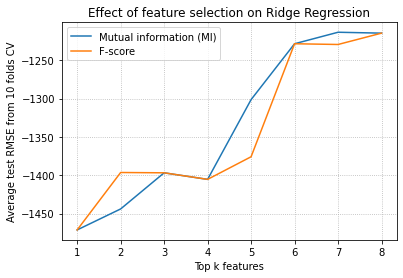

In [12]:
plt.plot(np.arange(1, len(Ridge_mi_list) + 1, 1), Ridge_mi_list)
plt.plot(np.arange(1, len(Ridge_f_list) + 1, 1), Ridge_f_list)
plt.legend(['Mutual information (MI)','F-score'], loc='best')
plt.grid(linestyle=':')
plt.xlabel('Top k features')
plt.ylabel('Average test RMSE from 10 folds CV')
plt.title('Effect of feature selection on Ridge Regression')
plt.show()

From above results, we can first tell that as we selects more features into the model, the performance of the model increases as we expected.
Therefore, the feature selection method indeed affects all the model we choose here.

Furthermore, there are no significant increases after we selects features more than 6, it might suggest that there are two features that don't affect the performance a lot.

Next, we will print out the top 2 influential features that has the lowest MI.

In [13]:
K = 2
MI = SelectKBest(score_func=mutual_info_regression, k=K).fit(X, y)
mask = MI.get_support()
best_features = X.columns[mask]
print('best %i features have the lowest MI:' %K)
print([item for item in best_features])

best 2 features have the lowest MI:
['carat', 'y']


We print out the best 6 features for the dataset, and we will use these 6 features in the following Question 4 model training.

In [14]:
K = 6
# Mutual information (MI)
MI = SelectKBest(score_func=mutual_info_regression, k=K).fit(X, y)
mask = MI.get_support()
best_features = X.columns[mask]
print('best %i features have the lowest MI:' %K)
print([item for item in best_features])
# F scores
F = SelectKBest(score_func=f_regression, k=K).fit(X, y)
mask = F.get_support()
best_features = X.columns[mask]
print('best %i features have the lowest F scores:' %K)
print([item for item in best_features])

best 6 features have the lowest MI:
['carat', 'color', 'clarity', 'x', 'y', 'z']
best 6 features have the lowest F scores:
['carat', 'color', 'clarity', 'x', 'y', 'z']


In [15]:
X_best = SelectKBest(score_func=mutual_info_regression, k=K).fit_transform(X, y)
# standardidzation X_best
sc = StandardScaler()
X_best_s = sc.fit_transform(X_best)

# Training and Evaluation

## Question 3

Explain what OOB error and $R^2$ score means.

OOB error:

The out-of-bag error (OOB error) is a measurement we use in Random Forest model. The Random Forest model uses bootstrap aggregation method to train the model. There will be many bootstraps (bagging), and each tree in the model will sample data points from their respective bootstraps. 

For each data point we sampled, we use them and their predictions from the trees that do not contain them to calculate the error. The average error for each data points are the OOB error here.

$R^2$ score:

The coefficient of determination. The proportion of the variation in the dependent variable that is predictable from the independent variables.

Its formula is usually interpreted as: $$1 - \frac{\sum_i(y_i - y_{pred_i})^2}{\sum_i(y_i - \overline{y})^2}$$

As you can see, it normally ranges from 0 to 1. As it gets closer to 1, it means that the model is more fitting into the data. And the correlation between the predicted value and true value is also higher.

## Linear Regression

What is the objective function? 

Train three models: 

(a) ordinary least squares (linear
regression without regularization)

(b) Lasso regression

(c) Ridge regression

Objective function

(a) ordinary least squares

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right)^2 $$

(b) Lasso regression

$$ J(\theta) = \frac{1}{2m} \left[ \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right)^2 + \lambda \sum_{j=1}^{n} |\theta_j| \right] $$

(c) Ridge regression

$$ J(\theta) = \frac{1}{2m} \left[ \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right)^2 + \lambda \sum_{j=1}^{n} \theta_j^2 \right] $$

Where:

$J(\theta)$ represents the objective function, which we are trying to minimize
$\theta$ is the vector of model parameters (coefficients or weights) that we want to estimate.

$m$ is the number of training examples in our dataset.

$x^{(i)}$ represents the feature vector (input) of the $i$-th training example.

$y^{(i)}$ represents the true (target) value of the $i$-th training example.

$h_\theta(x^{(i)})$ is the predicted value of the target variable for the $i$-th training example, based on our model parameters $\theta$.

$n$ is the number of features in the input data.

$\lambda$ is the regularization parameter, which controls the strength of the regularization.


### Question 4.1

Explain how each regularization scheme affects the learned parameter set.

There are two types of regularizations, L1 regularization and L2 regularization.
Lasso regression refers to linear regression with L1 regularization, and Ridge regression refers to linear regression with L2 regularization.

Next, we discuss the effects of these two regularizations respectively:

- Lasso regression:

  - Feature selection: Lasso regression tends to set some of the coefficients of the features to exactly zero. This means that Lasso regression can be used for feature selection, bacause it eliminates some of the less important features from the model. This can lead to simpler and more interpretable models, as well as better generalization performance.

  - Shrinking: Lasso regression shrinks the coefficients of the remaining features towards zero.  This can be seen as a form of automatic feature selection, as the model tends to give more weight to the most important features. It also leads to sparse solutions where many of the coefficients are zero or very small.

- Ridge regression:
  
  - Stabilizing: Ridge regression helps us stabilize the estimates of the coefficients and make them less sensitive to small changes in the input data by reducing the correlation between the features. It reduces the risk of overfitting and improves the generalization performance of the model.

  - Shrinking: Ridge regression can also shrink the coefficients of the features towards zero. But unlike Lasso regression did, it doesn't set any coefficients to exactly zero. Since it uses the sum of the squared values of model parameters as the penalty term. It's smooth and therefore has a continuous derivative.


### Question 4.2

Report your choice of the best regularization scheme along with the optimal penalty
parameter and explain how you computed it.

A:

We use the grid search package (cross validation) we learned in the project 1 to search the optimal penalty parameter for both lasso regression and ridge regression. And the sklearn.model_selection.cross_validate package is used for linear regression.

After investigation, the best regularization scheme is lasso regression (L1 regularization), and  its corresponding penalty parameter ($\lambda$) is $10^{-5}$. Its test RMSE is -1228.2203178503921.

#### Linear regression

In [30]:
lr_CV = cross_validate(LinearRegression(), X_best, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
lr_CV_s = cross_validate(LinearRegression(), X_best_s, y, scoring=['neg_root_mean_squared_error'], cv=10, n_jobs=-1)
print('[No standardization] Linear Regression \nits test RMSE:', lr_CV['test_neg_root_mean_squared_error'].mean())
print('[Standardization] Linear Regression \nits test RMSE:', lr_CV_s['test_neg_root_mean_squared_error'].mean())

[No standardization] Linear Regression 
its test RMSE: -1228.2203041711923
[Standardization] Linear Regression 
its test RMSE: -1228.220304171109


#### Lasso regression

In [31]:
pipeline_lasso = Pipeline([('model', Lasso(random_state=42))])
param_grid = {
    'model__alpha': [10.0**x for x in np.arange(-5, 3)]}

In [32]:
lasso_CV = GridSearchCV(pipeline_lasso, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(X_best, y)
lasso_CV_s = GridSearchCV(pipeline_lasso, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(X_best_s, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits


In [33]:
print('[No standardization] Best parameters:', lasso_CV.best_params_, '\nits test RMSE:', lasso_CV.best_score_)
print('[Standardization] Best parameters:', lasso_CV_s.best_params_, '\nits test RMSE:', lasso_CV_s.best_score_)

[No standardization] Best parameters: {'model__alpha': 1e-05} 
its test RMSE: -1228.2203178503921
[Standardization] Best parameters: {'model__alpha': 1e-05} 
its test RMSE: -1228.220312114747


#### Ridge regression

In [34]:
pipeline_ridge = Pipeline([('model', Ridge(random_state=42))])
param_grid = {
    'model__alpha': [10.0**x for x in np.arange(-5, 3)]}

In [35]:
ridge_CV = GridSearchCV(pipeline_ridge, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(X_best, y)
ridge_CV_s = GridSearchCV(pipeline_ridge, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(X_best_s, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits


In [36]:
print('[No standardization] Best parameters:', ridge_CV.best_params_, '\nits test RMSE:', ridge_CV.best_score_)
print('[Standardization] Best parameters:', ridge_CV_s.best_params_, '\nits test RMSE:', ridge_CV_s.best_score_)

[No standardization] Best parameters: {'model__alpha': 1e-05} 
its test RMSE: -1228.2203070191495
[Standardization] Best parameters: {'model__alpha': 1e-05} 
its test RMSE: -1228.220304758364


### Question 4.3

Does feature standardization play a role in improving the model performance (in
the cases with ridge regularization)? 

No. From the result above, it instead increase the test RMSE a little bit. 

However, it seems like all the optimal test RMSE we got here all similar to each other significantly.
It might because that this dataset is already converged to a state so that any regularization or standardization doens't affect the performance.

### Question 4.4

Some linear regression packages return p-values for different features. What is the meaning of these p-values and how can you infer the most significant features?

The p-values are used to measure the significance of the relationship between the predictor variables and the response variable. It indicates the probability of obtaining a result equal to or more extreme than what was actually observed under the null hypothesis.

If the p-value for a particular predictor variable is less than a  significance level we set (ex: 0.05), it indicates that there is a significant relationship between the predictor and the response variable.

On the other hand, if the p-value for a particular predictor variable is greater than the significance level, it indicates that there is insufficient evidence to reject the null hypothesis, and the variable may not be significantly related to the response variable.

## Polynomial Regression

Perform polynomial regression by crafting products of features you selected in part 3.1.4
up to a certain degree (max degree 6) and applying ridge regression on the compound
features. You can use scikit-learn library to build such features. Avoid overfitting by
proper regularization. Answer the following:

In [48]:
degrees = np.arange(1, 7)
pipeline_ridge_pr = Pipeline([
    ('PR', PolynomialFeatures()),
    ('model', Ridge(random_state=42))
])

param_grid_PR = {
    'PR__degree': degrees,
    'model__alpha': [10.0**x for x in np.arange(-5, 3)]
}

In [49]:
ridge_CV_pr = GridSearchCV(pipeline_ridge_pr, param_grid=param_grid_PR, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(X_best, y)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


### Question 5.1

What are the most salient features? Why? 

In [114]:
K = 6
selector = SelectKBest(score_func=f_regression, k=K)
X_best_6 = selector.fit_transform(X, y)
mask = selector.get_support()
best_features = X.columns[mask]

params = ridge_CV_pr.best_estimator_.get_params()
coefs = params['model'].coef_
feature_name = list(best_features)
names = params['PR'].get_feature_names_out(feature_name)
sorted_indice = np.argsort(-abs(coefs))
salient_features =[names[i] for i in sorted_indice[:K]]
print ('Top 6 salient features:', salient_features)

Top 6 salient features: ['carat', 'x', 'clarity', 'z', 'color', 'y']


From the result, the most salient feature of the dataset is 'carat'. Furthermore, the top 6 salient features of the dataset are 'carat', 'x', 'clarity', 'z', 'color', and 'y'.

It makes sense as we mentioned before, the price (target value) of a diamonds is highly correlated with its size.

### Question 5.2

What degree of polynomial is best? How did you find the optimal degree? What
does a very high-order polynomial imply about the fit on the training data? What
about its performance on testing data?

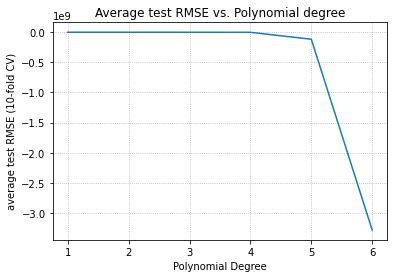

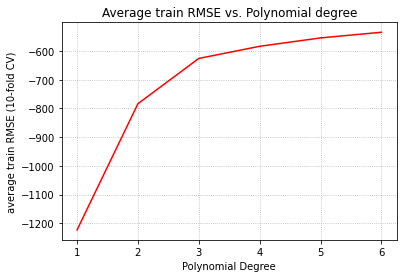

In [77]:
polyResults = pd.DataFrame(ridge_CV_pr.cv_results_)[['mean_test_score', 'mean_train_score', 'param_PR__degree', 'param_model__alpha']]
test_rmses = []
train_rmses = []
for i in degrees:
    test_rmses.append(polyResults[polyResults['param_PR__degree'] == i]['mean_test_score'].mean())
    train_rmses.append(polyResults[polyResults['param_PR__degree'] == i]['mean_train_score'].mean())

plt.plot(degrees, test_rmses)
plt.grid(linestyle=':')
plt.xlabel('Polynomial Degree')
plt.ylabel('average test RMSE (10-fold CV)')
plt.title('Average test RMSE vs. Polynomial degree')
plt.show()
plt.plot(degrees, train_rmses,'r')
plt.grid(linestyle=':')
plt.xlabel('Polynomial Degree')
plt.ylabel('average train RMSE (10-fold CV)')
plt.title('Average train RMSE vs. Polynomial degree')
plt.show()

We use the best 6 features we found with the cross validation method to find the best penalty parameter ($\lambda$) and its corresponding RMSE.

Combining the result for test RMSE and training RMSE for this dataset, we the best degree of polynomial here is 4.

A very high-order polynomial implies that it might overfit to the training data.

As you can see, when the polynomoal degree increases to 5 and 6, the training RMSE are still increasing but the test RMSE gets worser suddenly. Its performance on testing data is worse than the one in polynomial order 4.

## Neural Network

You will train a multi-layer perceptron (fully connected neural network). You can simply
use the sklearn implementation:

### Question 6.1

Adjust your network size (number of hidden neurons and depth), and weight decay
as regularization. Find a good hyper-parameter set systematically (no more than
20 experiments in total).

In [ ]:
hiddens = [(10,), (20,), (50,), (100,), (200,)]
# activations = ['relu', 'tanh']
activations = ['relu']

In [ ]:
pipeline_MLP = Pipeline([
    ('model', MLPRegressor(random_state=42, max_iter=1000))
])
                         
param_grid_MLP = {
    'model__hidden_layer_sizes': hiddens,
    'model__alpha': [10.0**x for x in np.arange(-4, -2)],
    'model__activation': activations  
}

In [ ]:
MLP_CV = GridSearchCV(pipeline_MLP, param_grid=param_grid_MLP, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(X_best, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print('Best parameters:', MLP_CV.best_params_, '\nits test RMSE:', MLP_CV.best_score_)

Best parameters: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (200,)} 
its test RMSE: -651.5086299443827


**Note:**

Since the execution time of the grid Search of MLP takes **MUCH** longer than we expect, we only implement grid search on different hidden layers size and hyperparameter alpha to see the differences.

For other hyperparameters, we take the result from other models as a reference to set the values directly.

### Question 6.2

How does the performance generally compare with linear regression? Why?

Comparing to the performance of linear regression, the performance of Neural Network (MLP) is much better. Its best test RMSE is approximately -651 and the best test RMSE for linear regression is approximately -1228.

It might because that MLP are more capable to capture the non-linear relationships between features and target variable. Linear regression assumes that the relationship between features and target variable is linear, which limits its performance and neural network doesn't have this limitation.

### Question 6.3

What activation function did you use for the output and why? You may use none.

I choose 'relu' as the activation function for the output. Because it's efficient to compute and should help us reduce training time. On the other hand, it's non-linear and has a large gradient for positive inputs, the latter helps us mitigate the vanishing gradient problem.

Lastly, it's a popular choice in many famous models we learned. Taking these into consideration, we choose 'relu' as the activation function.

### Question 6.4

What is the risk of increasing the depth of the network too far?

It will cause the model overfitting to the training data, where the model performs well on the training data but poorly on the test data. 

On the other hand, it might cause gradients vanishing problem, which makes the gradients in the backpropagation too small so that it becomes difficult to learn the representations in the layers.

Also, the computational complexity is another significant risk we should also consider. It will lead to a longer training times and memory requirements.

## Random Forest

We will train a random forest regression model on datasets, and answer the following:

In [ ]:
pipeline_RF = Pipeline([('model', RandomForestRegressor(max_depth=4, oob_score=True, random_state=42))])
param_grid_RF = {
    'model__max_features': [2, 4, 6, 8],
    'model__n_estimators': np.arange(10, 110, 10)
}

In [ ]:
RF_CV = GridSearchCV(pipeline_RF, param_grid=param_grid_RF, cv=10, n_jobs=-1, verbose=1, 
                     scoring='neg_root_mean_squared_error', return_train_score=True).fit(X_best, y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [ ]:
print('Best parameters:', RF_CV.best_params_, '\nits test RMSE:', RF_CV.best_score_)

Best parameters: {'model__max_features': 4, 'model__n_estimators': 90} 
its test RMSE: -1272.4571982712566


### Question 7.1

Random forests have the following hyper-parameters:

- Maximum number of features;

- Number of trees;

- Depth of each tree;

Explain how these hyper-parameters affect the overall performance. Describe if
and how each hyper-parameter results in a regularization effect during training.

- Maximum number of features:

  It means the maximum number of features that can be used for each split in each tree. 
  
  When it's setting to a lower value, it reduces overfitting. It should be useful when there are too many features in the dataset. 
  
  When it's setting to a higher value, it increases the expressiveness of the model by allowing the model capture more complex relationship in the data. But it also increase the possibility of overfitting as well.


- Number of trees:

  It means the number of decision trees that will be used in the random forest.

  By increasing this number, it can improve the stability and robustness of our model, but also increases the computational complexity of training as well.

- Depth of each tree:

  It means the maximum depth of each decision tree in the random forest.

  Increasing the depth can make the model more expressive and able to capture more complex relationships in the data. But similar to the number of trees, it can also lead to overfitting and slower training times.



### Question 7.2

How do random forests create a highly non-linear decision boundary despite the fact that all we do at each layer is apply a threshold on a feature? 

It creates a highly non-linear decision boundary by combineing multiple decision trees, each of which can create a piecewise linear boundary. While each individual decision tree may only apply a threshold on a single feature at each node, the combination of multiple trees with different thresholds and different features can create a more complex and non-linear boundary.

### Question 7.3

Randomly pick a tree in your random forest model (with maximum depth of 4) and plot its structure.

In [ ]:
RF = RandomForestRegressor(max_features=4, n_estimators=90, max_depth=4, oob_score=True, random_state=42)
RF.fit(X_best, y)

RandomForestRegressor(max_depth=4, max_features=4, n_estimators=90,
                      oob_score=True, random_state=42)

In [ ]:
K = 6
selector = SelectKBest(score_func=f_regression, k=K)
X_best_6 = selector.fit_transform(X, y)
mask = selector.get_support()
best_features = X.columns[mask]

feature_name = list(best_features)

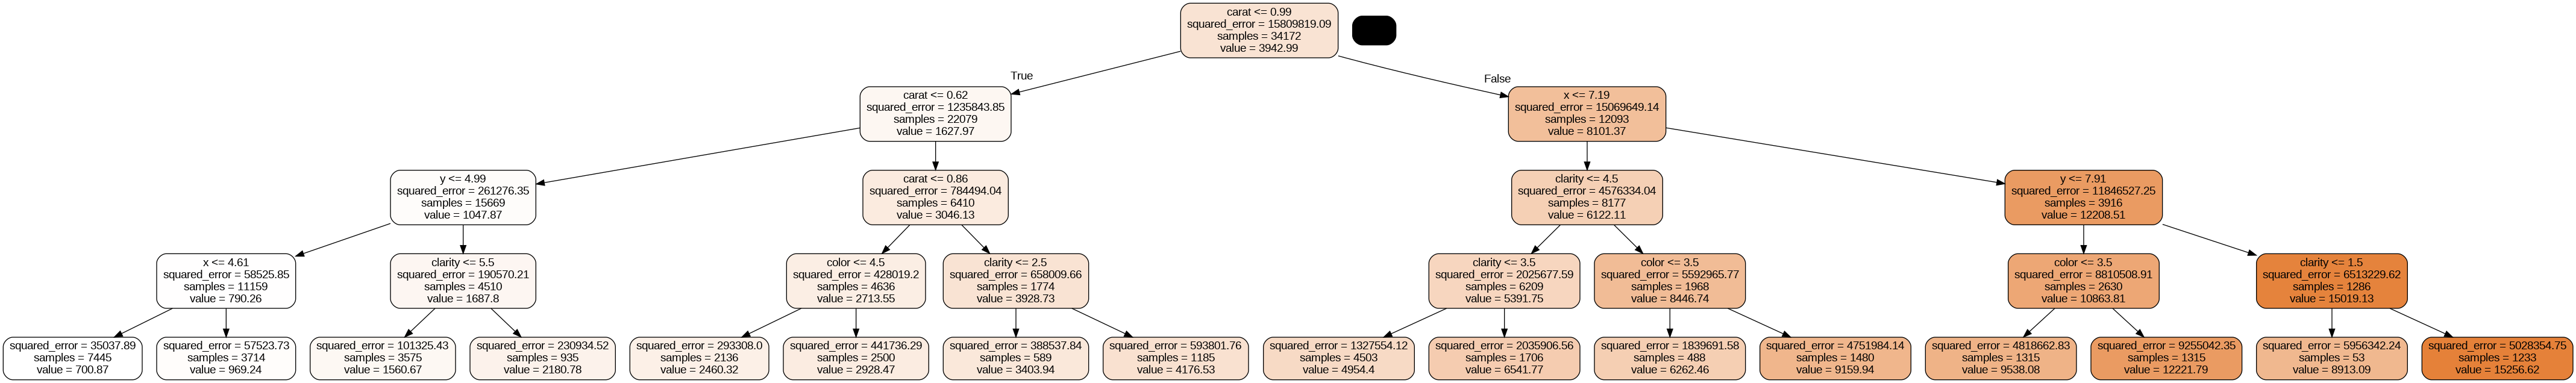

In [ ]:
t = random.randint(1, 10)
tree = RF.estimators_[t]
export_graphviz(tree, out_file = 'tree.dot', feature_names=feature_name, 
                filled=True, rounded=True, precision=2)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
Image(graph.create_png())

Which feature is selected for branching at the root node? What
can you infer about the importance of this feature as opposed to others? Do the
important features correspond to what you got in part 3.3.1?

It uses 'carat' for braching at the root node. It is also the same most important feature we found in part 3.3.1.

From here, we can infer that 'carat' is the most important feature when it classifies the price of a diamond. When 'carat' is smaller than a threshold (for example: 0.99 in the example above), the price of these diamonds are lower than those whose 'carat' os higher than 1.0.



### Question 7.4

Measure “Out-of-Bag Error” (OOB). Explain what OOB error and R2 score means.

In [ ]:
print('OOB error:', RF.oob_score_)
print('R^2 score:', RF.score(X_best, y))

OOB error: 0.929808662919192
R^2 score: 0.9310408317188389


From above result, we get a high OOB error rate but also a high $R^2$ score of the randomforest model.

It indicates that our model is possibly overfitting to the training data. Since it shows that we get a high correlation between X_best and y, but still having the high OOB error here.

## LightGBM, CatBoost and Bayesian Optimization

Boosted tree methods have shown advantages when dealing with tabular data, and recent
advances make these algorithms scalable to large scale data and enable natural treatment
of (high-cardinality) categorical features. Two of the most successful examples are LightGBM and CatBoost.

Both algorithms have many hyperparameters that influence their performance. This
results in large search space of hyperparameters, making the tuning of the hyperparameters hard with naive random search and grid search. Therefore, one may want to utilize
“smarter” hyperparameter search schemes. We specifically explore one of them: Bayesian
optimization.

In this part, pick either one of the datasets and apply LightGBM OR CatBoost. If
you do both, we will only look at the first one.


We choose LightGBM in further processes.

### Question 8.1

Read the documentation of LightGBM OR CatBoost and determine the important
hyperparameters along with a search space for the tuning of these parameters (keep
the search space small).

After reading the documentation of LightGBM, we determine the parameters set we want to search as below:

Boosting_type should be important since they are two different algorithms here. and 'gbdt' is a well-known decision tree algorithm which performs well on many dataset.

For other hyperparameters, we choose those which we already discussed (max_depth, n_estimators, reg_alpha, reg_lambda). And also min_split_gain, as it gets lower should result in deeper trees.


- boosting_type: 

  ‘gbdt’ vs. 'dart'
  
  (traditional Gradient Boosting Decision Tree) vs. (dropouts meet Multiple Additive Regression Trees)

- max_depth:

  the maximum tree depth for base learners.

- n_estimators:

  Number of boosted trees to fit.

- min_split_gain: 

  Minimum loss reduction required to make a further partition on a leaf node of the tree.

- reg_alpha:

  $\lambda$ in L1 regularization.

- reg_lambda:

  $\lambda$ in L2 regularization.

There are other hyperparameters that are also still important to the model. But due to the computation complexity, we only use the default value in the tuning grid search. Here we list them for further reference:

- subsample:

  Subsample ratio of the training instance.

- subsample_freq:

  Frequency of subsample.


In [ ]:
param_grid_lgbm = {
        'boosting_type': ['gbdt', 'dart'],
        'max_depth': [20, 50],
        'n_estimators': [1000],
        'min_split_gain': [10.0**x for x in np.arange(-2,0)],
        'reg_alpha': [10.0**x for x in np.arange(-4,-2)],
        'reg_lambda': [10.0**x for x in np.arange(-4,-2)]
}

### Question 8.2

Apply Bayesian optimization using skopt.BayesSearchCV from scikit-optmize
to find the ideal hyperparameter combination in your search space. Report the best
hyperparameter set found and the corresponding RMSE. 

In [ ]:
lgbm_CV = BayesSearchCV(
    lgb.LGBMRegressor(random_state=42,verbose=1,n_jobs=-1), param_grid_lgbm,
    n_iter=20, cv=10, n_jobs=-1, verbose=1, random_state=42,
    scoring = 'neg_root_mean_squared_error', return_train_score = True
).fit(X_best, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [ ]:
print('Best parameters:', lgbm_CV.best_params_, '\nits test RMSE:', lgbm_CV.best_score_)

Best parameters: OrderedDict([('boosting_type', 'dart'), ('max_depth', 48), ('min_split_gain', 0.019437324269743324), ('n_estimators', 1000), ('reg_alpha', 0.00026915966773061374), ('reg_lambda', 0.0005082988094256691)]) 
its test RMSE: -638.197799679928


### Question 8.3

Qualitatively interpret the effect of the hyperparameters using the Bayesian optimization results: Which of them helps with performance? Which helps with regularization (shrinks the generalization gap)? Which affects the fitting efficiency?

- Helping with performance:
  
  - max_depth

    Setting it larger can help to improve performance but also lead to overfitting when we increases it too much.

  - n_estimators

    Setting it larger can help to improve performance but also increase the training time.

  - subsample

    Setting it smaller than 1.0 to improve performance and faster training time. But it will lead to underfitting when its value is too low.

  - subsample_freq

    Setting it higher will perform subsampling more frequently. This can help to prevent overfitting and improve performance.

- Helping with regularization:

  - reg_alpha ($\lambda$ for L1)

  - reg_lambda ($\lambda$ for L2)

  - min_split_gain

  - Increasing the values of these hyperparameters can result in stronger regularization to prevent overfitting.

- Affecting the fitting efficiency:

  - max_depth

    Setting it larger can result in longer training times and reduced fitting efficiency.

  - n_estimators

    Setting it larger can help to improve performance but also increase the training  and reduce the fitting efficiency.

  - subsample

    Setting it smaller than 1.0 can result in faster training times and improve fitting efficiency.

  - subsample_freq

    Setting it higher will perform subsampling more frequently. This can help to prevent overfitting and affect the fitting efficiency.


# Twitter Data

In [ ]:
import json
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
import datetime, time
import pytz
import csv

## Question 9.1

Report the following statistics for each hashtag, i.e. each file has: 

- Average number of tweets per hour
- Average number of followers of users posting the tweets per tweet (to make it simple,
we average over the number of tweets; if a users posted twice, we count the user
and the user’s followers twice as 
well)

- Average number of retweets per tweet

In [ ]:
tweet_data_path = path + '/tweet_data/'

In [ ]:
hashtags = ['#GoHawks', '#GoPatriots', '#NFL', '#Patriots', '#SB49', '#SuperBowl']
hashtag_filenames = {'#GoHawks': tweet_data_path + 'tweets_#gohawks.txt',
                    '#GoPatriots': tweet_data_path + 'tweets_#gopatriots.txt',
                    '#NFL': tweet_data_path + 'tweets_#nfl.txt',
                    '#Patriots': tweet_data_path + 'tweets_#patriots.txt',
                    '#SB49': tweet_data_path + 'tweets_#sb49.txt',
                    '#SuperBowl': tweet_data_path + 'tweets_#superbowl.txt'}

In [ ]:
for hashtag in hashtags:
  hash_file = open(hashtag_filenames[hashtag])

  time_stamps = []
  num_retweets = []
  num_followers = []

  for line in hash_file:
      tweet = json.loads(line)
      time_stamps.append(tweet['citation_date'])
      num_retweets.append(tweet['metrics']['citations']['total'])
      num_followers.append(tweet['author']['followers'])

  hash_file.close()

  hours = float(max(time_stamps) - min(time_stamps)) / 3600.0
  num_tweets = len(time_stamps)
  num_retweets = sum(num_retweets)
  num_followers = sum(num_followers)
  print('\nHashtag', hashtag, ":")
  print('Average number of tweets per hour:', num_tweets / hours)
  print('Average number of followers of users posting the tweets per tweet:',
        num_followers / num_tweets)
  print('Average number of retweets per tweet:', num_retweets / num_tweets, "\n")


Hashtag #GoHawks :
Average number of tweets per hour: 292.48785062173687
Average number of followers of users posting the tweets per tweet: 2217.9237355281984
Average number of retweets per tweet: 2.0132093991319877 


Hashtag #GoPatriots :
Average number of tweets per hour: 40.95469800606194
Average number of followers of users posting the tweets per tweet: 1427.2526051635405
Average number of retweets per tweet: 1.4081919101697078 


Hashtag #NFL :
Average number of tweets per hour: 397.0213901819841
Average number of followers of users posting the tweets per tweet: 4662.37544523693
Average number of retweets per tweet: 1.5344602655543254 


Hashtag #Patriots :
Average number of tweets per hour: 750.89426460689
Average number of followers of users posting the tweets per tweet: 3280.4635616550277
Average number of retweets per tweet: 1.7852871288476946 


Hashtag #SB49 :
Average number of tweets per hour: 1276.8570598680474
Average number of followers of users posting the tweets per 

## Question 9.2

Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with
1-hour bins). The tweets are stored in separate files for different hashtags and files are
named as tweet [#hashtag].txt

Hashtag #SuperBowl :


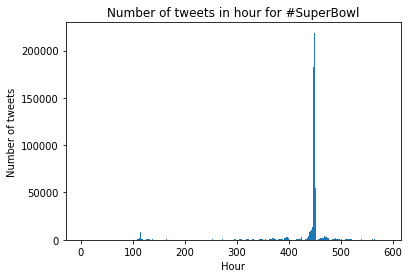

Hashtag #NFL :


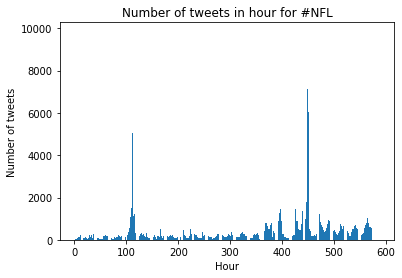

In [ ]:
for hashtag in ['#SuperBowl', '#NFL']:
  hash_file = open(hashtag_filenames[hashtag])

  time_stamps = []
  num_retweets = []
  num_followers = []

  for line in hash_file:
      tweet = json.loads(line)
      time_stamps.append(tweet['citation_date'])
      num_retweets.append(tweet['metrics']['citations']['total'])
      num_followers.append(tweet['author']['followers'])

  hash_file.close()

  hours = float(max(time_stamps) - min(time_stamps)) / 3600.0
  num_tweets = len(time_stamps)
  num_retweets = sum(num_retweets)
  num_followers = sum(num_followers)

  tweet_per_hour = [0] * (int(hours) + 1)
  start_time = min(time_stamps)
  for time_stamp in time_stamps:
      tweet_per_hour[int((time_stamp - start_time) / 3600)] += 1
  
  print('Hashtag', hashtag, ":")
  plt.figure()
  plt.bar(range(1, len(tweet_per_hour) + 1), tweet_per_hour)
  plt.xlabel('Hour')
  plt.ylabel('Number of tweets')
  plt.title('Number of tweets in hour for ' + hashtag)
  plt.show()

## Question 10

- Describe your task.

- Explore the data and any metadata (you can even incorporate additional datasets
if you choose).

- Describe the feature engineering process. Implement it with reason: Why are you
extracting features this way - why not in any other way?

- Generate baselines for your final ML model.

- A thorough evaluation is necessary.

- Be creative in your task design - use things you have learned in other classes too if
you are excited about them!

### Describe your task

Since the Super Bowl this year just ended last month, we are more interested in the #SuperBowl data and trying to get some interesting insight from the dataset.

First, here is the approximate game time of the 2015 Super Bowl:


   **Feb. 1st, 3:30 p.m. ~ Feb. 1st, 7:30 p.m. (PST)**


Next, the most naive idea we can do is to train a model predicts the number of tweets given current tweets data and timestamp (before and after the game). 

If it goes well, we can do further modeling to build a more sophisticated model. For example, a sentiment analysis to see if the fans mood are change as their supporting team is winning or losing.

### Explore the data and any metadata

 (you can even incorporate additional datasets if you choose).

In [ ]:
hashtag = '#SuperBowl'
hash_file = open(hashtag_filenames[hashtag])
look_column = None
for line in hash_file:
    look_column = json.loads(line)
    break
print('features in the twitter data:\n', [item for item in look_column.keys()])

features in the twitter data:
 ['firstpost_date', 'title', 'url', 'tweet', 'author', 'original_author', 'citation_date', 'metrics', 'highlight', 'type', 'citation_url']


### Describe the feature engineering process. 

Implement it with reason: Why are you extracting features this way - why not in any other way?

The features we choose: (all numerical)

- Tweet hour:

  When the tweet was sent. (int, 0~23)

- Tweet number per hour:

  The total number of tweets in a tweet hour.

- Retweet number:

  The total number of retweets in the tweet hours of the tweet.

- Reply number:

  The total number of replies of the tweet.

- Favorite number:

  The total number of favorite a tweet received.

- Impression score:

  The average of impressions of the tweet.

- Ranking score:

  The average ranking score of a tweet.

- Follower number:

  The total number of followers of the user.

- Influence level:

  The average influence level of the author.

These features are most used in twitter and have already been captured by this dataset. They should help us for further analysis.

In [ ]:
def extracting_data_2_csv(file, hashtag, path):
    pst_tz = pytz.timezone('US/Pacific')
    
    with open(file) as f:
      for line in f:
          item = json.loads(line)
          with open(path + hashtag +'.csv', 'a') as csv_file:
              wr = csv.writer(csv_file)
              csv_list = [item["citation_date"], item["author"]["name"], item["metrics"]["citations"]["total"],
                      item["author"]["followers"], item.get('author').get('influence_level'),
                      item['metrics']['ranking_score'], item.get('metrics').get('citations').get('replies'),
                      item.get('metrics').get('impressions'),item['tweet']['favorite_count'],
                      datetime.datetime.fromtimestamp(item["citation_date"], pst_tz).hour, 1, 
                      item['tweet']['user']['location'], item['title']]
              wr.writerow(csv_list)
              csv_file.close()  

In [ ]:
hashtags = ['#GoHawks', '#GoPatriots', '#NFL', '#Patriots', '#SB49', '#SuperBowl']
hashtag_filenames = {'#GoHawks': path + 'tweets_#gohawks.txt',
                    '#GoPatriots': path + 'tweets_#gopatriots.txt',
                    '#NFL': path + 'tweets_#nfl.txt',
                    '#Patriots': path + 'tweets_#patriots.txt',
                    '#SB49': path + 'tweets_#sb49.txt',
                    '#SuperBowl': path + 'tweets_#superbowl.txt'}

for hashtag in hashtags:
  print('current hashtag', hashtag, '...')
  extracting_data_2_csv(hashtag_filenames[hashtag], hashtag.split('#')[1], path)

Here, we choose basic regression models we just learned or learned before. Separating the dataset using the game time we have, training each models respectively, then we should get a preliminary result to check our idea is feasible or not.

In [ ]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

In [ ]:
def simple_cv(X, y, model_name):
    result = []
   
    KF = KFold(n_splits=10, shuffle=True, random_state=42)
    # i = 0
    # print('10-fold cross valication')
    for train, test in KF.split(X):
        # print(i, '...')
        # i+=1
        # print(train)
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        
        # Random Forest
        if model_name == 'rf':
            model = RandomForestRegressor(n_estimators=90, random_state=42)
            model.fit(X_train, y_train)

        # Linear Regression
        if model_name == 'lr':
            model = sm.OLS(y_train, X_train).fit()

        # # SVM
        # if model_name == 'svm':
        #     model = svm.SVC(gamma=6)
        #     model.fit(X_train, y_train)
        
        # LightGBM
        if model_name == 'lgbm':
            model = lgb.LGBMRegressor(boosting_type='dart', max_depth=10, n_estimators=100,
                                      random_state=42, verbose=0, n_jobs=-1)
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        error = np.abs(y_pred - y_test)
        error = np.mean(error)
        result.append(error)
    
    return np.mean(result)

def load_data(df):
    df = df.set_index('date')
    hour_data = df.groupby('date', as_index=False).resample('H')
    hour_data_sum = hour_data.aggregate(np.sum).reset_index()
    hour_data_sum = hour_data_sum.drop('level_0', axis=1)
    # chane datetime back to timestamp for further model training
    hour_data_sum['date'] = hour_data_sum['date'].astype('int64') // 10**9
    X = hour_data_sum.drop('tweets', axis=1)
    y = hour_data_sum['tweets']
    return X, y

Note:

It takes longer than we expected to run the cross validation. To finish it efficiently, we only choose the simple model and calculate its corresponding mean absolute error.

(We want to use SVM at first but eventually replace it with linear regression since it takes TOO long to finish.)

In [ ]:
def print_mae_error(df, file, model):
    game_start = datetime.datetime(2015,2,1,15,30,0)
    game_end = datetime.datetime(2015,2,1,19,30,0)
    

    df1 = df[df['date'] < game_start]
    X, y = load_data(df1)
    mae = simple_cv(X, y, model)
    print ('[before Super Bowl] the mean absolute error of', file, ':', mae)
    
    df2_1 = df[df['date'] >= game_start]
    df2 = df2_1[df2_1['date'] <= game_end]
    X, y = load_data(df2)
    mae = simple_cv(X, y, model)
    print ('[During Super Bowl] the mean absolute error of', file, ':', mae)

    df3 = df[df['date'] > game_end]
    mae = simple_cv(X, y,model)
    print ('[After Super Bowl] the mean absolute error of', file, ':', mae)

In [ ]:
def READ_CSV(path, hashtag):
    df = pd.read_csv(path + hashtag + ".csv", header=None)
    features=['date', 'author', 'tweets', 'followers', 'influence_level',
              'ranking_score', 'replies','impressions', 'favorite_count',
              'retweets', 'empty', 'location', 'title']
    df.columns = features
    df = df.drop('author', axis=1)
    df = df.drop('empty', axis=1)
    df = df.drop('location', axis=1)
    df = df.drop('title', axis=1)
    df.fillna(0)
    df['date'] = pd.to_datetime(df['date'], unit='s')
    return df

In [ ]:
hashtags = ['#GoHawks', '#GoPatriots', '#NFL', '#Patriots', '#SB49', '#SuperBowl']
csv_row_dict = {'GoHawks':188136, 'GoPatriots':26232, 'NFL':259024,
                'Patriots':489713, 'SB49':826951, 'SuperBowl':1348767}
features=['date','tweets','retweets','followers','influence_level','replies','ranking_score',
          'impressions','favorite_count']
models = ['lr', 'rf', 'lgbm']
dic = {'rf': 'Random Forest',
       'lr': 'Linear Regression (Ordinary Least Squares)',
       'lgbm': 'LightGBM'}
for hashtag in hashtags:
    hashtag = hashtag.split('#')[1]
    print('[DATA]', hashtag, ':')
    df = READ_CSV(path, hashtag)
    for model in models:
        print ('\n', dic[model], ":")
        print_mae_error(df, hashtag, model)

[DATA] GoHawks :

 Linear Regression (Ordinary Least Squares) :
[before Super Bowl] the mean absolute error of GoHawks : 1.6933179504163913
[During Super Bowl] the mean absolute error of GoHawks : 0.9913888303457398
[After Super Bowl] the mean absolute error of GoHawks : 0.9913888303457398

 Random Forest :
[before Super Bowl] the mean absolute error of GoHawks : 1.5492460574777873
[During Super Bowl] the mean absolute error of GoHawks : 0.8998269895581904
[After Super Bowl] the mean absolute error of GoHawks : 0.8998269895581904

 LightGBM :
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

KeyboardInterrupt: ignored

[DATA] GoHawks :

 Linear Regression (Ordinary Least Squares) :

[before Super Bowl] the mean absolute error of GoHawks : 1.6933179504163913

[During Super Bowl] the mean absolute error of GoHawks : 0.9913888303457398

[After Super Bowl] the mean absolute error of GoHawks : 0.9913888303457398

 Random Forest :

[before Super Bowl] the mean absolute error of GoHawks : 1.5492460574777873

[During Super Bowl] the mean absolute error of GoHawks : 0.8998269895581904

[After Super Bowl] the mean absolute error of GoHawks : 0.8998269895581904

 LightGBM :

 [before Super Bowl] the mean absolute error of GoHawks : 1.573533711155059

 [During Super Bowl] the mean absolute error of GoPatriots : 0.3940723456024303

 [After Super Bowl] the mean absolute error of GoPatriots : 0.3940723456024303

 [DATA] NFL :

 Linear Regression (Ordinary Least Squares) :

[before Super Bowl] the mean absolute error of NFL : 1.0029145353462097

[During Super Bowl] the mean absolute error of NFL : 0.8775295650575707

[After Super Bowl] the mean absolute error of NFL : 0.8775295650575707

 Random Forest :

[before Super Bowl] the mean absolute error of NFL : 0.9096860268924878

[During Super Bowl] the mean absolute error of NFL : 0.8038262963461509

[After Super Bowl] the mean absolute error of NFL : 0.8038262963461509

 LightGBM :

[before Super Bowl] the mean absolute error of NFL : 0.8749576518786324

[During Super Bowl] the mean absolute error of NFL : 0.7721058606954924

[After Super Bowl] the mean absolute error of NFL : 0.7721058606954924


From above result, we can see that LightGBM performs best among these three models no matter in any one of the dataset. 

However, the performance during and after the Super Bowl looks like the same.
We will discuss this in next step. We want to use the best model we found and the whole dataset the measure it.


Note: We only show the GoHawks and NFL data here since it takes too long time to finish all of the datasets. We have also used others in previous training which looks pretty similar as well.

In [ ]:
hashtags = ['#GoHawks', '#GoPatriots', '#NFL', '#Patriots', '#SB49', '#SuperBowl']
# merging the files
df_list = []
for hashtag in hashtags:
  hashtag = hashtag.split('#')[1]
  # read each csv into a dataframe
  tmp_df = pd.read_csv(path + hashtag + '.csv')
  features=['date', 'author', 'tweets', 'followers', 'influence_level',
            'ranking_score', 'replies','impressions', 'favorite_count',
            'retweets', 'empty', 'location', 'title']
  tmp_df.columns = features
  tmp_df = tmp_df.drop('author', axis=1)
  tmp_df = tmp_df.drop('empty', axis=1)
  tmp_df = tmp_df.drop('location', axis=1)
  tmp_df = tmp_df.drop('title', axis=1)
  tmp_df.fillna(0)
  tmp_df['date'] = pd.to_datetime(tmp_df['date'], unit='s')
  df_list.append(tmp_df)

# merge dfs into one dataframe
twitter_df = df_list[0]
for i in range(1, len(df_list)):
  twitter_df = pd.merge(twitter_df, df_list[i], how='outer')
twitter_df

,date,tweets,followers,influence_level,ranking_score,replies,impressions,favorite_count,retweets
0,2015-01-14 18:18:56,2,258.0,NaN,3.646109,0,162,0,18
1,2015-01-17 04:21:59,5,22.0,NaN,3.500887,0,5,0,4
2,2015-01-17 04:21:37,2,22.0,NaN,3.229207,0,5,0,4
3,2015-01-17 04:18:56,2,22.0,NaN,3.759005,0,5,1,4
4,2015-01-17 04:16:16,2,22.0,NaN,3.718140,0,5,1,4
...,...,...,...,...,...,...,...,...,...
2356058,2015-02-07 07:55:57,1,1725.0,2.0,3.508782,0,1723,0,7
2356059,2015-02-07 07:56:44,1,69.0,NaN,3.962029,0,66,0,7
2356060,2015-02-07 07:57:19,1,2.0,NaN,3.409577,0,2,0,7
2356061,2015-02-07 07:59:26,1,131.0,1.0,4.183085,0,129,0,7


In [ ]:
best_model = 'lgbm'
# print out the result for the whole data
print('Using the whole data:')
print_mae_error(twitter_df, 'whole dataset', best_model)

Using the whole data:
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[before Super Bowl] the mean absolute error of whole dataset : 2.2127587387862824

[During Super Bowl] the mean absolute error of whole dataset : 8.048020419054591

[After Super Bowl] the mean absolute error of whole dataset : 8.048020419054591

From the above results, we first confirm that the error during the game proceeds is worse. However, almost every mean absolute error between 'During Super Bowl' and 'After Super Bowl' looks like the same. It might because that the fans are still talking about the game after it finished.

But in the case of separate data, one of the possible reason is that our timestamp choice doesn't separate the dataset greatly. It suggests that we should modify the timeline to receive more data (tweets) into consideration. For example, extending it into a period and calculating the average/count numbers might be agood alternative.

### Generate baselines for your final ML model

From previous result, we found that we need to catch more data into consideration. And 
we know that the game is approximately started at 15:30 and ended at 19:30. Therefore, we translate the timeline into 12:00 to 18:00, and consider tweets which last for 8 hours. It should make sense since people usually gather with friends to have the lunch and watch Super Bowl starting at 12.

Next, we do the sentimental anlysis during the game to see if the tweets from fans are affected by the teams.
(tweets with '#gohawks' represents fans tweet from hawks; tweets with '#gopatriots' represents fans tweet from patriots)

In [47]:
import json
import math
import datetime, time
from datetime import timedelta
import pytz
from pytz import timezone
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
import calendar
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
def cleaning(text):
    #clean words
    # split into words
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    #remove the word after hashtag
    idx= []
    tokens_list = []
    for i in range(len(tokens)):
        if i == 0:
            idx.append(0)
        elif (tokens[i-1] != '#'):
                idx.append(i)
        pass
    pass
    for i in idx:
        tokens_list.append(tokens[i])
    pass

    # remove the symbol
    words = [w for w in tokens_list if w.isalpha()]
    #remove customized word
    words1 = [w for w in words if not w in ['http']]
    #remove stopwords
    stop_words = stopwords.words('english')
    words = [w for w in words1 if not w in stop_words]

    #combine stem words together
    porter = PorterStemmer()
    stemmed = [porter.stem(w) for w in words]
    return stemmed

In [65]:
def sentimental_analysis(text_file, teamname):
  f = open(path + text_file, 'r')
  timestamp = []
  tweet_count = []
  followers_count = []
  retweet_count = []
  content = []
  with f as cur_file:
      for line in cur_file:
      #json_object = json.loads(line)
          data = json.loads(line)
          timestamp.append(data['citation_date'])
          tweet_count.append(1)
          followers_count.append(data['author']['followers'])
          retweet_count.append(data['metrics']['citations']['total'])
          content.append(data['title'])

  ###

  timestamp = pd.to_datetime(timestamp, unit='s')
  twitter_final = pd.DataFrame({
      'tweet': tweet_count,
      'date': timestamp,
      'followers': followers_count,
      'retweet number': retweet_count,
      'content': content},
      columns=['tweet', 'date', 'followers', 'retweet times', 'content'])

  ###

  #cleaning the content words
  cleaned_word = []
  for i in range(twitter_final.shape[0]):#
      stemmed = cleaning(twitter_final['content'][i])#
      # join words to a sentence
      cleaned_word.append(' '.join(w for w in stemmed))
  # cleaned_word[:5]

  ###

  senti = SentimentIntensityAnalyzer()
  # positive
  pos_list = []
  # negative
  neg_list = []
  # neutral
  neu_list = []
  for i in range(twitter_final.shape[0]):
      ss = senti.polarity_scores(cleaned_word[i])
      pos_list.append(ss['pos'])
      neg_list.append(ss['neg'])
      neu_list.append(ss['neu'])
    
  twitter_senti = pd.DataFrame({
    'pos': pos_list,
    'neg': neg_list,
    'neu': neu_list,
    'date': timestamp,
    'cleaned_word': cleaned_word
    },
    columns=['pos', 'neg', 'neu', 'date', 'cleaned_word'])
  twitter_senti_ov = twitter_senti
  pos_ov = []
  neg_ov = []
  for i in range(twitter_senti.shape[0]):
      if twitter_senti['pos'][i] > twitter_senti['neg'][i]:
          pos_ov.append(1)
          neg_ov.append(0)
      elif twitter_senti['pos'][i] < twitter_senti['neg'][i]:
          pos_ov.append(0)
          neg_ov.append(1)
      else:
          pos_ov.append(0)
          neg_ov.append(0)
  twitter_senti_ov['pos_ov'] = pos_ov
  twitter_senti_ov['neg_ov'] = neg_ov

  ###

  pos_list_m = []
  pos_list_c = []
  neg_list_m = []
  neg_list_c = []
  list_c = []
  # game_start = datetime.datetime(2015,2,1,12,0,0)
  # game_end = datetime.datetime(2015,2,1,18,0,0)
  for i in range(0, 10* 49, 10):
      game_start_8hr = datetime.datetime(2015, 2, 1, 12 + i//60, i%60, 0) + timedelta(hours=8)
      game_end_8hr = datetime.datetime(2015, 2, 1, 12 + (i+10)//60 , (i+10)%60, 0) + timedelta(hours=8)
      twitter_senti_ov_1 = twitter_senti_ov[twitter_senti_ov['date'] >= game_start_8hr]
      twitter_senti_ov_ingame = twitter_senti_ov_1[twitter_senti_ov_1['date'] <= game_end_8hr]
      row_num = twitter_senti_ov_ingame.shape[0]
      list_c.append(row_num)

      pos_list_m.append(np.mean(twitter_senti_ov_ingame['pos']))
      pos_list_c.append(np.sum(twitter_senti_ov_ingame['pos_ov']) / row_num)

      neg_list_m.append(np.mean(twitter_senti_ov_ingame['neg']))
      neg_list_c.append(np.sum(twitter_senti_ov_ingame['neg_ov']) / row_num)
  
  ###

  plt.plot(list_c)
  plt.ylabel('Comment count')
  plt.xlabel('Starting from 12:00 [unit: 10 min]')
  plt.title('[' + str(teamname) + '] Comment counts vs. time')
  plt.show()

  ###

  plt.plot(pos_list_c)
  plt.plot(neg_list_c)
  plt.ylabel('Comment count')
  plt.xlabel('Starting from 12:00 [unit: 10 min]')
  plt.title('[' + str(teamname) + '] Positive and Negative comment vs. time')
  plt.legend(['positive', 'negative'], loc='best')
  plt.show()

  ###

  pos_list_c_n = np.copy((pos_list_c - np.mean(twitter_senti_ov['pos_ov'])) / np.std(twitter_senti_ov['pos_ov']))
  neg_list_c_n = np.copy((neg_list_c - np.mean(twitter_senti_ov['neg_ov'])) / np.std(twitter_senti_ov['neg_ov']))

  ###

  plt.plot(pos_list_c_n)
  plt.plot(neg_list_c_n)
  plt.ylabel('[Normalize] Comment count')
  plt.xlabel('Starting from 12:00 [unit: 10 min]')
  plt.title('[' + str(teamname) + '] Positive and Negative comment vs. time [Normalize]')
  plt.legend(['positive', 'negative'], loc='best')
  plt.show()

  ###

  posneg = pos_list_c_n - neg_list_c_n

  return posneg

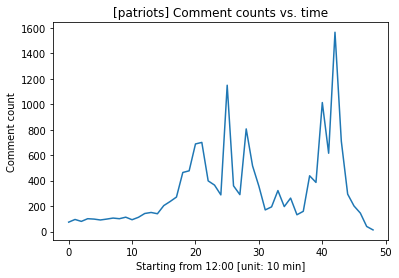

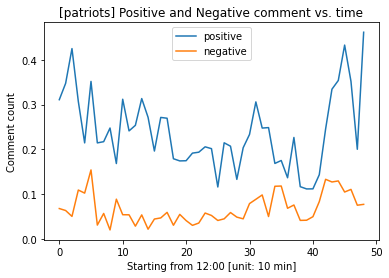

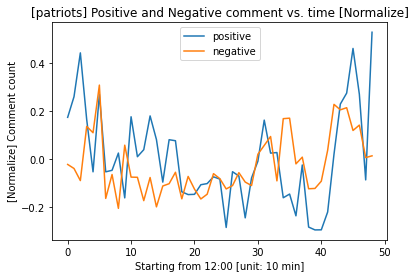

In [66]:
patriots_posneg = sentimental_analysis('tweets_#gopatriots.txt', 'patriots')

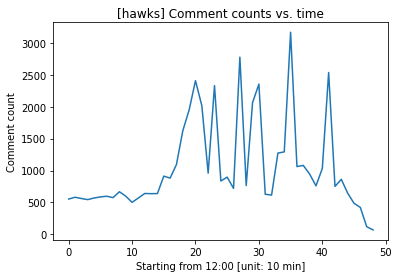

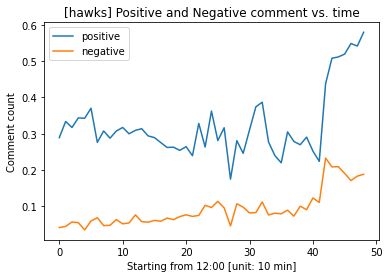

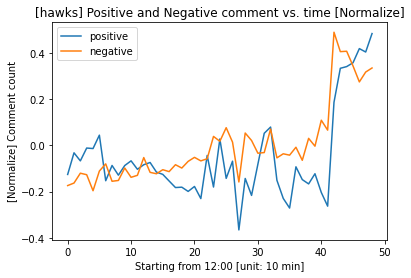

In [67]:
hawks_posneg = sentimental_analysis('tweets_#gohawks.txt', 'hawks')

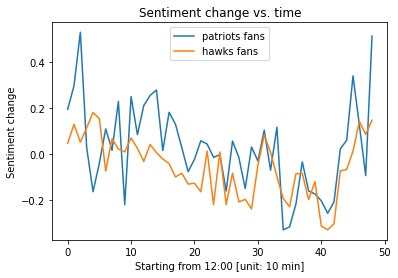

In [69]:
plt.plot(patriots_posneg)
plt.plot(hawks_posneg)
plt.ylabel('Sentiment change')
plt.xlabel('Starting from 12:00 [unit: 10 min]')
plt.title('Sentiment change vs. time')
plt.legend(['patriots fans', 'hawks fans'], loc='best')
plt.show()

### Evaluation

Finally, the results above are the sentiment analysis graphs after modifying the timestamp.

As you can see, the emotion of fans doesn'y look like have different tendency between these opponent teams. Basically, their sentiment are consistent with each other according to the data we have.

Looking into the trending graph for each team separately, we can still see that the trends between positive and negative are still consistent.

This result is quite interesting and not what we expect in the beginning. We thought that when positive tweets from one team increase, the positive tweets for the other team should decrease, and vice versa. Apparently, it's different from what we think.

To explain this result, it might because that the Super Bowl game has now became a popular show for everyone who likes sport to join and watch. The audiences don't have particular teams to support. They might also tags both two teams' hashtag when they are sending tweets during the game. Therefore, it causes there are similar trending for positive or negative sentiment. They all increase as the game approaches the end of the game.